# DFA 3-Layer Network

**Ted Moskovitz, September 2017**

Backprop with implemenation of direct feedback alignment (See Nokland 2016 in Papers Folder). Trained on MNIST.

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc as spm
import cPickle, gzip

%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.size'] = 22

In [97]:
# Load the dataset
f = gzip.open('./Data/mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()

In [98]:
X_train, y_train = train_set
X_val, y_val = valid_set
X_test, y_test = test_set

In [99]:
def convert_one_hot(labels, n_classes=10, th=False):
    oh_labels = np.zeros((len(labels), n_classes))
    if th:
        oh_labels.fill(-1.)
    for i in xrange(len(labels)):
        oh_labels[i,:][labels[i]] = 1.
    return oh_labels                       

In [100]:
y_train_oh = convert_one_hot(y_train, th=False)
y_val_oh = convert_one_hot(y_val, th=False)
y_test_oh = convert_one_hot(y_test, th=False)

In [101]:
# if no validation
#y_train = np.reshape(np.vstack((y_train.reshape(50000,1), y_val.reshape(10000,1))), (60000,))
X_train = np.vstack((X_train, X_val))
y_train_oh = convert_one_hot(y_train, th=False)
print y_train.shape

(50000,)


In [102]:
num_train = X_train.shape[0]
num_val = X_val.shape[0]
num_test = X_test.shape[0]

In [192]:
epsinit = .01
eta = .00001
decay = .000001

n0 = X_train.shape[1]
n1 = 50
n2 = 50
n3 = 10


W1 = epsinit * np.random.randn(n1, n0)
b1 = epsinit * np.random.randn(n1, 1)

W2 = epsinit * np.random.randn(n2, n1)
b2 = epsinit * np.random.randn(n2, 1)

W3 = epsinit * np.random.randn(n3, n2)
b3 = epsinit * np.random.randn(n3, 1)

R2 = epsinit * np.random.randn(n2, n3) # constant random matrix shape of W3.T
#R1 = epsinit * np.random.randn(n, n2) # constant random matrix shape of W3.T

tmax = 200000#0
tshow = 5000#0
loss = np.zeros((tmax,))
avgloss = np.zeros((tmax/tshow,))

mvalidate = len(y_val)
val_loss = np.zeros((tmax/tshow,))
errcl = np.zeros((tmax,))
avgerrcl = np.zeros((tmax/tshow,))

In [193]:
def get_minibatch(inp, targ, size):
    i = int(np.random.rand() * (len(targ) - size)) 
    return inp[i:i+size,:].T, targ[i:i+size]

In [194]:
def f(x):
    return 1. / (1. + np.exp(-x))
def df(y):
    return np.multiply(y, 1.-y)

In [195]:
def tanh(a):              # tanh activation function 
    return np.tanh(a) 
def dtanh(b):             # derivative of tanh
    return 1 - (b**2)

In [196]:
def soft(x):
    return np.log(1. + np.exp(x))
def dsoft(x): # unlike other deriv fns here, is wrt preactivation (u) not activation (x) 
    return f(x)

In [197]:
def spec_soft(x):
    a = 10.
    return (1./a)*np.log(1.+np.exp(a*x))
def dspec_soft(x):
    a = 10.
    return f(a*x)

In [198]:
def sq_loss(y, yhat, n):
    return sum(sum(np.power((y-yhat), 2))) / n

In [199]:
def poiss_loss(y, yhat, n):
    return np.mean(yhat - y * np.log(yhat + 1e-7) + np.log(spm.factorial(y)), axis=-1)

In [200]:
def cross_entropy_loss(y, yhat, n):
    return -np.mean(np.mean(y*np.log(yhat+1e-7) + (1.-y)*np.log(1.-yhat+1e-7), axis=0))

In [201]:
def neglogli(preds, actual):
    preds = np.reshape(preds, (-1,))
    nll = np.sum((preds - actual*np.log(preds + 1e-07) + np.log(spm.factorial(actual))))
    return nll

In [202]:
def predict(x0, wts, bs):
    W1, W2, W3 = wts
    b1, b2, b3 = bs
    
    sz = x0.shape[1]
    B1 = np.repeat(b1, sz).reshape([n1, sz])
    B2 = np.repeat(b2, sz).reshape([n2, sz])
    B3 = np.repeat(b3, sz).reshape([n3, sz])
    
    h1 = f(np.dot(W1,x0) + B1)
    h2 = f(np.dot(W2,h1) + B2)
    preds = f(np.dot(W3,h2) + B3)
    
    return preds

In [203]:
bsize = 16
predicted = np.zeros((tmax/tshow,bsize))
ys = np.zeros((tmax/tshow, bsize))
for t in xrange(tmax):
    x0, y = get_minibatch(X_train, y_train_oh, bsize)
    y = y.T
    
    B1 = np.repeat(b1, bsize).reshape([n1, bsize])
    B2 = np.repeat(b2, bsize).reshape([n2, bsize])
    B3 = np.repeat(b3, bsize).reshape([n3, bsize])
    
    # forward pass
    u1 = np.dot(W1,x0)+B1
    x1 = f(u1)
    u2 = np.dot(W2,x1)+B2
    x2 = f(u2)
    u3 = np.dot(W3,x2)+B3
    x3 = f(u3)

    #loss[t] = sq_loss(y, x2, bsize)
    loss[t] = cross_entropy_loss(y, x3, bsize)
    
    errcl[t] = float(np.sum(np.argmax(x3,axis=0) != np.argmax(y,axis=0)))/bsize
    
    # backward pass
    #delta3 = (y - x2) * df(x2) # sq loss
    #delta3 = -np.multiply((1. - np.divide(y, x2+1e-7)), df(x2)) # poiss loss
    #delta3 = -np.multiply(np.divide(y,x3+1e-7) + np.divide(1.-y, 1.-x3+1e-7), df(x3)) # cross entropy loss
    delta3 = -np.divide((x3 - y), np.multiply(y, 1.-y)+1e-7)
    
    fast_back = np.dot(R2, delta3)

    delta2 = np.multiply(fast_back, df(x2))
    
    delta1 = np.multiply(fast_back, df(x1)) # DFA
    '''
    if (float(t)/tmax) == .75:
        print 'Learning Rate Annealed'
        eta /= 5.
    '''   
    W3 += eta / bsize * np.dot(delta3, x2.T)
    W2 += eta / bsize * np.dot(delta2, x1.T)
    W1 += eta / bsize * np.dot(delta1, x0.T)
    
    b3 += eta / bsize * np.sum(delta3, axis=1).reshape(n3, 1)
    b2 += eta / bsize * np.sum(delta2, axis=1).reshape(n2, 1)
    b1 += eta / bsize * np.sum(delta1, axis=1).reshape(n1, 1)
    
    eta *= (1.-decay) 
    
    if t % tshow == 0 and t > 0:
        print 'Epoch ' + str(t/tshow) + ' of ' + str(tmax/tshow-1) + ':'
    
        avgloss[t/tshow-1] = np.sum(loss[:t]) / float(t+1)
        avgerrcl[t/tshow-1] = np.sum(errcl[:t]) / float(t)
        #predicted[t/tshow-1,:] = x2
        #ys[t/tshow-1,:] = y
        print "Avg. Train Loss: " + str(avgloss[t/tshow-1])
        print 'Avg. Class Error: ' + str(avgerrcl[t/tshow-1])
        
        '''
        # validation loss
        x0 = X_val.T
        
        B1 = np.repeat(b1, mvalidate).reshape([n1, mvalidate])
        B2 = np.repeat(b2, mvalidate).reshape([n2, mvalidate])
        x1 = f(np.dot(W1,x0)+B1)
        x2 = f(np.dot(W2,x1)+B2)
        
        #val_loss[t/tshow-1] = sq_loss(y_val.T, x2, mvalidate)
        val_loss[t/tshow-1] = sq_loss(y_val_oh.T, x2, mvalidate)
        
        print "Validation Loss: " + str(val_loss[t/tshow-1])
        '''
        print ' '
        
        

/Users/TedMoskovitz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


Epoch 1 of 39:
Avg. Train Loss: 0.833914718876
Avg. Class Error: 0.2594375
 
Epoch 2 of 39:
Avg. Train Loss: 0.630850808271
Avg. Class Error: 0.1944875
 
Epoch 3 of 39:
Avg. Train Loss: 0.540450936717
Avg. Class Error: 0.165841666667
 
Epoch 4 of 39:
Avg. Train Loss: 0.487652776006
Avg. Class Error: 0.148903125
 
Epoch 5 of 39:
Avg. Train Loss: 0.45175362319
Avg. Class Error: 0.137465
 
Epoch 6 of 39:
Avg. Train Loss: 0.424143423179
Avg. Class Error: 0.128658333333
 
Epoch 7 of 39:
Avg. Train Loss: 0.401856819533
Avg. Class Error: 0.1215875
 
Epoch 8 of 39:
Avg. Train Loss: 0.384640910819
Avg. Class Error: 0.116090625
 
Epoch 9 of 39:
Avg. Train Loss: 0.369185154385
Avg. Class Error: 0.1113
 
Epoch 10 of 39:
Avg. Train Loss: 0.356341849568
Avg. Class Error: 0.1072475
 
Epoch 11 of 39:
Avg. Train Loss: 0.345093662497
Avg. Class Error: 0.103672727273
 
Epoch 12 of 39:
Avg. Train Loss: 0.334368619331
Avg. Class Error: 0.100308333333
 
Epoch 13 of 39:
Avg. Train Loss: 0.324877002804
Avg. C

In [ ]:
w1 = np.mean(W1, axis=0)
print w1.shape
plt.plot(w1)
plt.show()

In [ ]:
for i in xrange(n1):
    plt.plot(W1[i,:])
    plt.show()

In [ ]:
plt.plot(ys[0,:], label='target')
plt.plot(predicted[0,:], label='prediction')
plt.legend()
plt.xlabel('Bins')
plt.ylabel('Spikes')
plt.title('Initial')
plt.show()

In [ ]:
plt.plot(ys[-2,:], label='target')
plt.plot(predicted[-2,:], label='prediction')
plt.legend()
plt.xlabel('Bins')
plt.ylabel('Spikes')
plt.title('Final')
plt.show()

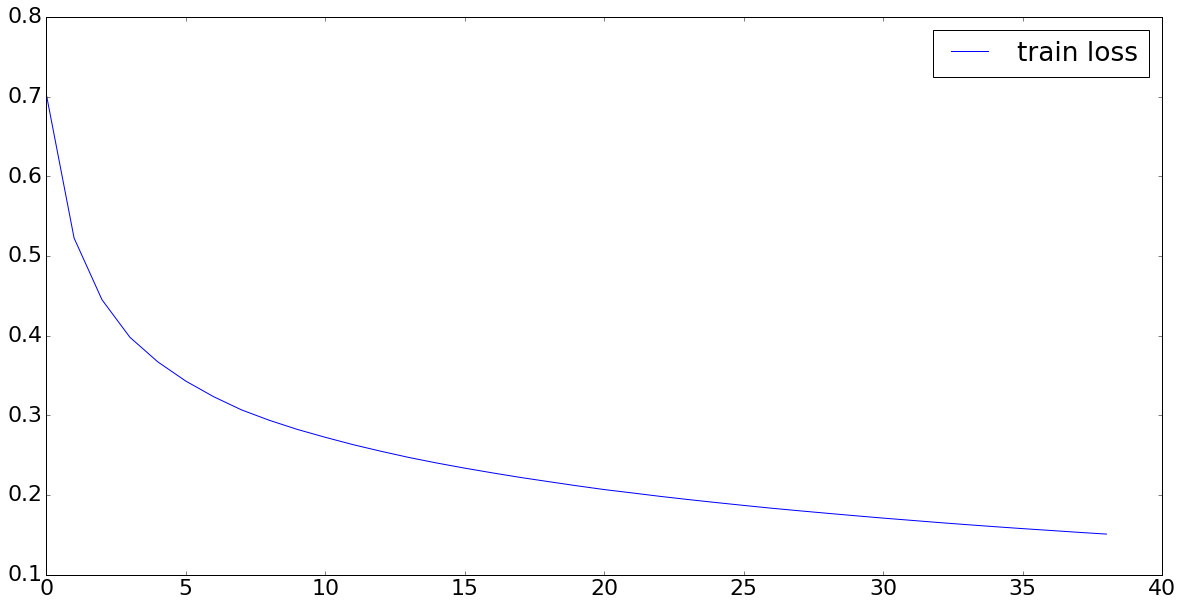

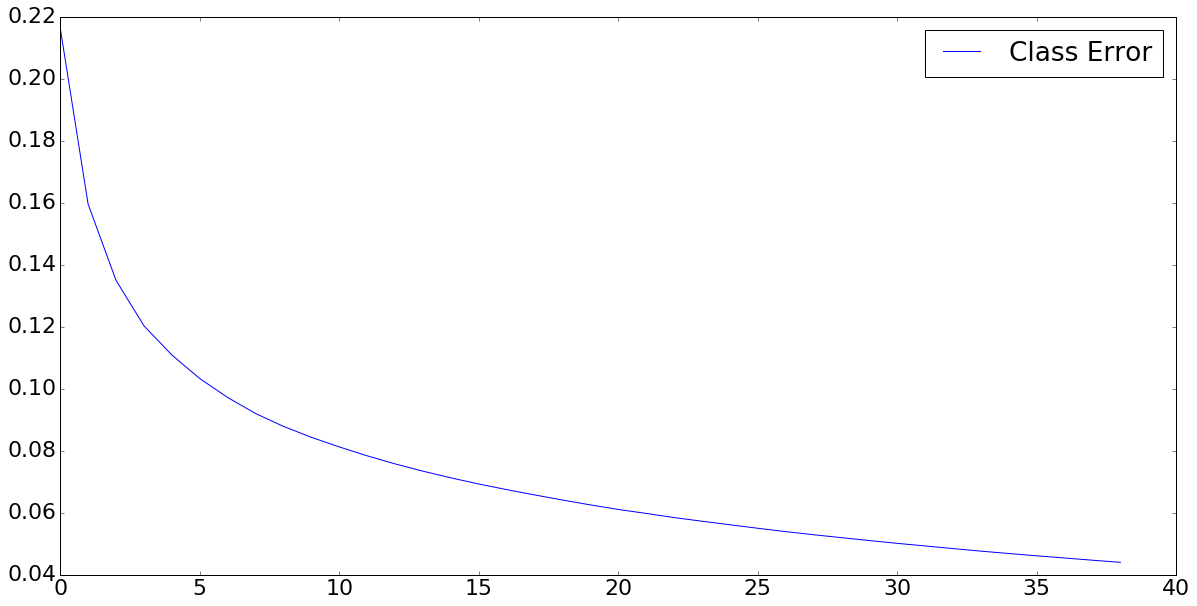

In [189]:
plt.plot(avgloss[:-1], label='train loss')
#plt.plot(val_loss[:-1], label='validation loss')
plt.legend()
plt.show()

plt.plot(avgerrcl[:-1], label='Class Error')
np.savetxt('./Results/MLP_DFA_784_50_50_10_classerr.csv', avgerrcl[:-1], delimiter=',')
plt.legend()
plt.show()

In [ ]:
print W1.shape
print W2.shape
print b1.shape
print b2.shape

In [204]:
wts = (W1, W2, W3)
bs = (b1, b2, b3)
preds = predict(X_test.T, wts, bs)
print preds.shape

print cross_entropy_loss(y_test_oh.T, preds, num_test)

print float(np.sum(np.argmax(preds,axis=0) != np.argmax(y_test_oh.T, axis=0))) / num_test

(10, 10000)
0.196216985099
0.0626


/Users/TedMoskovitz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


In [ ]:
r = int(np.random.rand() * len(y_test)) 
if r > 1000:
    r = r - 20
plt.plot(y_test[r:r+20], label='target')
plt.plot(predict(X_test[r:r+20,:].T, wts, bs).T, label='prediction')
plt.legend()
plt.xlabel('Bins')
plt.ylabel('Spikes')
plt.title('Test Points')
plt.show()

In [ ]:
B1 = np.repeat(b1, num_train).reshape([n1, num_train])
B2 = np.repeat(b2, num_train).reshape([n2, num_train])
filt_output0 = np.dot(W2, f(np.dot(W1, X_train.T) + B1)) + B2
#filt_output0 = np.dot(W1, X_train.T) + B1
print filt_output0.shape

In [ ]:
h1, bin_edges = np.histogram(filt_output0[0,:], bins=20)
plt.hist(filt_output0[0,:], bins=20)
plt.show()

In [ ]:
train_preds = predict(X_train.T, wts, bs)
train_preds = train_preds.T
print train_preds.shape